In [10]:
from sympy import *
from sympy.physics.mechanics import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

init_vprinting()

In [2]:
m1, m2, m3, l, g, t, tau2, tau3 = symbols('m1 m2 m3 l g t tau2 tau3')
theta1, theta2, theta3 = dynamicsymbols('theta1 theta2 theta3')

p1 = Matrix([[l*sin(theta1)], [-l*cos(theta1)]])
p2 = p1 + Matrix([[l*sin(theta1+theta2)], [-l*cos(theta1+theta2)]])
p3 = p2 + Matrix([[l*sin(theta1+theta2+theta3)], [-l*cos(theta1+theta2+theta3)]])

dp1 = Matrix([[diff(p1, theta1), diff(p1, theta2), diff(p1, theta3)]])
dp2 = Matrix([[diff(p2, theta1), diff(p2, theta2), diff(p2, theta3)]])
dp3 = Matrix([[diff(p3, theta1), diff(p3, theta2), diff(p3, theta3)]])

theta1_dot = diff(theta1, t)
theta2_dot = diff(theta2, t)
theta3_dot = diff(theta3, t)
theta1_ddot = diff(theta1_dot, t)
theta2_ddot = diff(theta2_dot, t)
theta3_ddot = diff(theta3_dot, t)

theta = Matrix([[theta1], [theta2], [theta3]])
theta_dot = Matrix([[theta1_dot], [theta2_dot], [theta3_dot]])
theta_ddot = Matrix([[theta1_ddot], [theta2_ddot], [theta3_ddot]])

U = -m1*g*p1[1] - m2*g*p2[1] - m3*g*p3[1]
K = (1/2*(m1*theta_dot.T*dp1.T*dp1*theta_dot + m2*theta_dot.T*dp2.T*dp2*theta_dot + m3*theta_dot.T*dp3.T*dp3*theta_dot))[0]
L = K - U

eqn1 = diff(diff(L, theta1_dot), t) - diff(L, theta1)
eqn2 = diff(diff(L, theta2_dot), t) - diff(L, theta2)
eqn3 = diff(diff(L, theta3_dot), t) - diff(L, theta3)

eqn = simplify(Matrix([[eqn1], [eqn2], [eqn3]]))
eqn

⎡  ⎛                                                                          
⎢l⋅⎝-g⋅m₁⋅sin(θ₁) - g⋅m₂⋅sin(θ₁ + θ₂) - g⋅m₂⋅sin(θ₁) - g⋅m₃⋅sin(θ₁ + θ₂) - g⋅m
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                                              
₃⋅sin(θ₁ + θ₂ + θ₃) - g⋅m₃⋅sin(θ₁) + 1.0⋅l⋅m₁⋅θ₁̈ - 2.0⋅l⋅m₂⋅sin(θ₂)⋅θ₁̇⋅θ₂̇ -
                                                                              
                                                                              
                                                   

In [3]:
M = simplify(m1*dp1.T*dp1 + m2*dp2.T*dp2 + m3*dp3.T*dp3)
N = simplify(eqn - M*theta_ddot)
M_bar = simplify(M[1:3, 1:3] - M[1:3, 0]*M[0, 1:3]/M[0, 0])
N_bar = simplify(N[1:3, 0] - M[1:3, 0]*N[0, 0]/M[0, 0])
M_bar_inv = M_bar.inv()

In [4]:
alpha = Matrix([[1], [-1]])
proj_term = eye(2) - alpha*alpha.T*M_bar_inv/(alpha.T*M_bar_inv*alpha)[0]
f = Matrix([
        [((-M[0, 1:3]*theta_ddot[1:3, 0])[0] - N[0, 0])/M[0, 0]], 
        M_bar_inv*proj_term*(N_bar - Matrix([[tau2], [tau3]]))
    ])

g = f.subs({theta1: 'theta1', theta2: 'theta2', theta3: 'theta3', theta1_dot: 'theta1_dot', theta2_dot: 'theta2_dot', theta3_dot: 'theta3_dot', theta1_ddot: 'theta1_ddot', theta2_ddot: 'theta2_ddot', theta3_ddot: 'theta3_ddot'})
print(f'theta2_ddot = {g[1]}')
print(f'theta3_ddot = {g[2]}')
print(f'theta1_ddot = {g[0]}\n')

theta2_ddot = (l*((m2*cos(theta2) + m2 + m3*cos(theta2) + 2*m3*cos(theta3) + m3*cos(theta2 + theta3) + 2*m3)*(1.0*g*m1*sin(theta1) + 1.0*g*m2*sin(theta1) + 1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) + 2.0*l*m2*theta1_dot*theta2_dot*sin(theta2) + 1.0*l*m2*theta2_dot**2*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta2_dot**2*sin(theta2) + 1.0*l*m3*theta2_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta2 + theta3)) - (m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3)*(1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2) + 1

In [5]:
m1 = 1
m2 = 1
m3 = 1
l = 1
g = 9.81

dt = 0.01
tf = 10
t = np.arange(0, tf, dt)

theta1_0 = 0
theta2_0 = np.pi/2
theta3_0 = np.pi/2
theta1_dot_0 = 0
theta2_dot_0 = 0
theta3_dot_0 = 0

def ODE(t, y):
    theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot = y
    tau2 = 0
    tau3 = 0
    theta2_ddot = (l*((m2*cos(theta2) + m2 + m3*cos(theta2) + 2*m3*cos(theta3) + m3*cos(theta2 + theta3) + 2*m3)*(1.0*g*m1*sin(theta1) + 1.0*g*m2*sin(theta1) + 1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) + 2.0*l*m2*theta1_dot*theta2_dot*sin(theta2) + 1.0*l*m2*theta2_dot**2*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta2_dot**2*sin(theta2) + 1.0*l*m3*theta2_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta2 + theta3)) - (m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3)*(1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) - 1.0*l*m2*theta1_dot**2*sin(theta2) - 1.0*l*m3*theta1_dot**2*sin(theta2) - 1.0*l*m3*theta1_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3)))/(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3) - tau2)*((-((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) - (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))/((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2)) + 1)*(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) - (-(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))) + ((-((m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))/((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2)) + 1)*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) - (-(m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) + (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2)))*(l*m3*((cos(theta3) + cos(theta2 + theta3) + 1)*(1.0*g*m1*sin(theta1) + 1.0*g*m2*sin(theta1) + 1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) + 2.0*l*m2*theta1_dot*theta2_dot*sin(theta2) + 1.0*l*m2*theta2_dot**2*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta2_dot**2*sin(theta2) + 1.0*l*m3*theta2_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta2 + theta3)) + (-1.0*g*sin(theta1 + theta2 + theta3) + 1.0*l*theta1_dot**2*sin(theta3) + 1.0*l*theta1_dot**2*sin(theta2 + theta3) + 2.0*l*theta1_dot*theta2_dot*sin(theta3) + 1.0*l*theta2_dot**2*sin(theta3))*(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3))/(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3) - tau3)
    theta3_ddot = (l*((m2*cos(theta2) + m2 + m3*cos(theta2) + 2*m3*cos(theta3) + m3*cos(theta2 + theta3) + 2*m3)*(1.0*g*m1*sin(theta1) + 1.0*g*m2*sin(theta1) + 1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) + 2.0*l*m2*theta1_dot*theta2_dot*sin(theta2) + 1.0*l*m2*theta2_dot**2*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta2_dot**2*sin(theta2) + 1.0*l*m3*theta2_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta2 + theta3)) - (m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3)*(1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) - 1.0*l*m2*theta1_dot**2*sin(theta2) - 1.0*l*m3*theta1_dot**2*sin(theta2) - 1.0*l*m3*theta1_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3)))/(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3) - tau2)*((-((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) - (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))/((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2)) + 1)*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) - (-(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3))) + ((-((m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))/((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2)) + 1)*(m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - (-(m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) + (-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(((m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) - m3*cos(theta3)**2 - 2*m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta2 + theta3)**2 + 2*m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2) + (m1*m2 + 2*m1*m3*cos(theta3) + 2*m1*m3 - m2**2*cos(theta2)**2 + m2**2 - 2*m2*m3*cos(theta2)**2 - 2*m2*m3*cos(theta2)*cos(theta2 + theta3) + 2*m2*m3*cos(theta3) + 3*m2*m3 - m3**2*cos(theta2)**2 - 2*m3**2*cos(theta2)*cos(theta2 + theta3) + 2*m3**2*cos(theta3) - m3**2*cos(theta2 + theta3)**2 + 2*m3**2)/(l**2*m1*m2*m3 - l**2*m1*m3**2*cos(theta3)**2 + l**2*m1*m3**2 - l**2*m2**2*m3*cos(theta2)**2 + l**2*m2**2*m3 - 2*l**2*m2*m3**2*cos(theta2)**2 + 2*l**2*m2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3**2*cos(theta3)**2 - l**2*m2*m3**2*cos(theta2 + theta3)**2 + 2*l**2*m2*m3**2 - l**2*m3**3*cos(theta2)**2 + 2*l**2*m3**3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**3*cos(theta3)**2 - l**2*m3**3*cos(theta2 + theta3)**2 + l**2*m3**3) - 2*(-m1*cos(theta3) - m1 - m2*cos(theta2)*cos(theta3) + m2*cos(theta2)*cos(theta2 + theta3) - m2*cos(theta2) - m2*cos(theta3) + m2*cos(theta2 + theta3) - m2 - m3*cos(theta2)*cos(theta3) + m3*cos(theta2)*cos(theta2 + theta3) - m3*cos(theta2) + m3*cos(theta3)*cos(theta2 + theta3) - m3*cos(theta3) + m3*cos(theta2 + theta3)**2 + m3*cos(theta2 + theta3) - m3)/(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2))*(l**2*m1*m2 - l**2*m1*m3*cos(theta3)**2 + l**2*m1*m3 - l**2*m2**2*cos(theta2)**2 + l**2*m2**2 - 2*l**2*m2*m3*cos(theta2)**2 + 2*l**2*m2*m3*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m2*m3*cos(theta3)**2 - l**2*m2*m3*cos(theta2 + theta3)**2 + 2*l**2*m2*m3 - l**2*m3**2*cos(theta2)**2 + 2*l**2*m3**2*cos(theta2)*cos(theta3)*cos(theta2 + theta3) - l**2*m3**2*cos(theta3)**2 - l**2*m3**2*cos(theta2 + theta3)**2 + l**2*m3**2)))*(l*m3*((cos(theta3) + cos(theta2 + theta3) + 1)*(1.0*g*m1*sin(theta1) + 1.0*g*m2*sin(theta1) + 1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) + 2.0*l*m2*theta1_dot*theta2_dot*sin(theta2) + 1.0*l*m2*theta2_dot**2*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta2_dot**2*sin(theta2) + 1.0*l*m3*theta2_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta2 + theta3)) + (-1.0*g*sin(theta1 + theta2 + theta3) + 1.0*l*theta1_dot**2*sin(theta3) + 1.0*l*theta1_dot**2*sin(theta2 + theta3) + 2.0*l*theta1_dot*theta2_dot*sin(theta3) + 1.0*l*theta2_dot**2*sin(theta3))*(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3))/(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3) - tau3)
    theta1_ddot = (-l**2*m3*theta3_ddot*(cos(theta3) + cos(theta2 + theta3) + 1) - l**2*theta2_ddot*(m2*cos(theta2) + m2 + m3*cos(theta2) + 2*m3*cos(theta3) + m3*cos(theta2 + theta3) + 2*m3) + l*(1.0*g*m1*sin(theta1) + 1.0*g*m2*sin(theta1) + 1.0*g*m2*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1) + 1.0*g*m3*sin(theta1 + theta2) + 1.0*g*m3*sin(theta1 + theta2 + theta3) + 2.0*l*m2*theta1_dot*theta2_dot*sin(theta2) + 1.0*l*m2*theta2_dot**2*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2) + 2.0*l*m3*theta1_dot*theta2_dot*sin(theta2 + theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta1_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta2_dot**2*sin(theta2) + 1.0*l*m3*theta2_dot**2*sin(theta2 + theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta3) + 2.0*l*m3*theta2_dot*theta3_dot*sin(theta2 + theta3) + 1.0*l*m3*theta3_dot**2*sin(theta3) + 1.0*l*m3*theta3_dot**2*sin(theta2 + theta3)))/(l**2*(m1 + 2*m2*cos(theta2) + 2*m2 + 2*m3*cos(theta2) + 2*m3*cos(theta3) + 2*m3*cos(theta2 + theta3) + 3*m3))
    return (theta1_dot, theta2_dot, theta3_dot, theta1_ddot, theta2_ddot, theta3_ddot)

sol = solve_ivp(ODE, (0, tf), (theta1_0, theta2_0, theta3_0, theta1_dot_0, theta2_dot_0, theta3_dot_0), t_eval=t)
theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot = sol.y

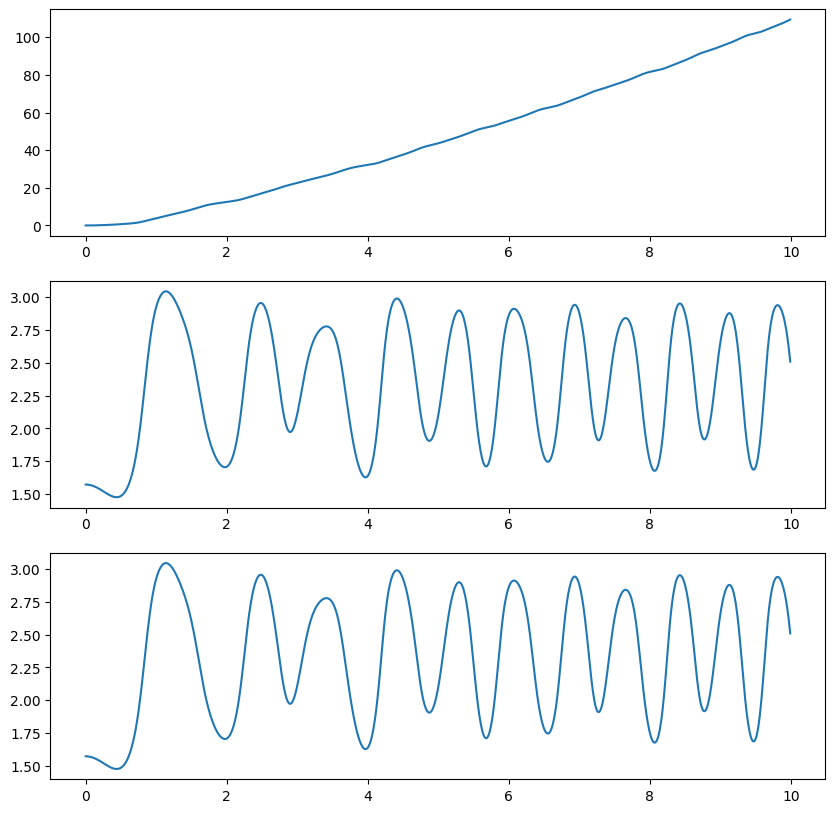

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(t, theta1, label=r'$\theta_1$')
plt.subplot(3, 1, 2)
plt.plot(t, theta2, label=r'$\theta_2$')
plt.subplot(3, 1, 3)
plt.plot(t, theta3, label=r'$\theta_3$')

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-3, 1), aspect='equal')
ax.grid()

# Plot initial position
line1 = ax.plot([0, l*np.sin(theta1[0])], [0, -l*np.cos(theta1[0])], 'o-', lw=2)[0]
line2 = ax.plot([l*np.sin(theta1[0]), l*np.sin(theta1[0])+l*sin(theta1[0]+theta2[0])], [-l*np.cos(theta1[0]), -l*np.cos(theta1[0])-l*np.cos(theta1[0]+theta2[0])], 'o-', lw=2)[0]
line3 = ax.plot([l*np.sin(theta1[0])+l*sin(theta1[0]+theta2[0]), l*np.sin(theta1[0])+l*sin(theta1[0]+theta2[0])+l*sin(theta1[0]+theta2[0]+theta3[0])], [-l*np.cos(theta1[0])-l*np.cos(theta1[0]+theta2[0]), -l*np.cos(theta1[0])-l*np.cos(theta1[0]+theta2[0])-l*np.cos(theta1[0]+theta2[0]+theta3[0])], 'o-', lw=2)[0]

# Text box for time and torque
#text = ax.text(0.05, 0.9, f'time: {t[0]:.1f} s\ntau: {tau[0]:.1f} Nm', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=18)

fps = 30
def animate(i):
    i = int(i/(fps*dt))
    line1.set_data([0, l*np.sin(theta1[i])], [0, -l*np.cos(theta1[i])])
    line2.set_data([l*np.sin(theta1[i]), l*np.sin(theta1[i])+l*sin(theta1[i]+theta2[i])], [-l*np.cos(theta1[i]), -l*np.cos(theta1[i])-l*np.cos(theta1[i]+theta2[i])])
    line3.set_data([l*np.sin(theta1[i])+l*sin(theta1[i]+theta2[i]), l*np.sin(theta1[i])+l*sin(theta1[i]+theta2[i])+l*sin(theta1[i]+theta2[i]+theta3[i])], [-l*np.cos(theta1[i])-l*np.cos(theta1[i]+theta2[i]), -l*np.cos(theta1[i])-l*np.cos(theta1[i]+theta2[i])-l*np.cos(theta1[i]+theta2[i]+theta3[i])])
    #text.set_text(f'time: {t[i]:.1f} s\ntau: {tau[i]:.1f} Nm')

tf_sim = tf
ani = animation.FuncAnimation(fig, animate, frames=fps*tf_sim)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'pendulizable.mp4', writer=ffmpeg_writer)
plt.close(fig)